In [57]:
vars = [var for var in globals() if var[0] != '_']
for var in vars:
    del globals()[var]

del var, vars

In [58]:
import numpy as np
import torch
import scipy.optimize as sci_opt
import sys
sys.path.append('../')
import module_opt_AD

import importlib
importlib.reload(module_opt_AD)

import matplotlib.pyplot as plt


/home/cykwonlab/NumericalOptimizationCourse25/Assignment_5/../module_opt_AD.py:1136: SyntaxWarning: invalid escape sequence '\:'
  f (callable) : objective function(output \: single scalar)


#### Define Functions(obj, constraint)

In [59]:
N = 45 # The number of positions of drone
T = 15.0 # Total flight time [sec]
vmax = 1.5 # Maximum velocity [unit / sec]

def f(dv):
    N = int(dv.shape[0]*.5)
    x = dv[:N]
    y = dv[N:]
    C = (1/((x - 5)**2 + (y - 5)**2 + 1)).sum()
    d_sq = np.array([(x[i+1] - x[i])**2 + (y[i+1] - y[i])**2 for i in np.arange(N-1)]).sum()
    return C + d_sq

def ce1(dv): # x1 = 0.0
    return dv[0]

def ce2(dv): # y1 = 0.0
    N = int(dv.shape[0]*.5)
    return dv[N]

def ce3(dv): # xN = 10.0
    N = int(dv.shape[0]*.5)
    return dv[N-1] - 10.0

def ce4(dv): # yN = 10.0
    return dv[-1] - 10.0

def ce5(dv): # (x2 - x1)/(15/(N - 1)) = 0.0 <-> u1 = 0.0
    N = int(dv.shape[0]*.5)
    return (dv[1] - dv[0])/(T/(N - 1))

def ce6(dv): # (y2 - y1)/(15/(N - 1)) = 0.0 <-> v1 = 0.0
    N = int(dv.shape[0]*.5)
    return (dv[N+1] - dv[N])/(T/(N - 1))

ci_x_larger_0 = [lambda dv, i=i : dv[i] for i in np.arange(N)] # xi >= 0.0
ci_x_smaller_10 = [lambda dv, i=i : -dv[i] + 10.0 for i in np.arange(N)] # xi <= 10.0
ci_y_larger_0 = [lambda dv, i=i : dv[N+i] for i in np.arange(N)] # yi >= 0.0
ci_y_smaller_10 = [lambda dv, i=i : -dv[N+i] + 10.0 for i in np.arange(N)] # yi <= 10.0
ci_v_smaller_vmax = [lambda dv, i=i : vmax**2 - (((dv[i+1] - dv[i])/(T/(N - 1)))**2 + ((dv[N+i+1] - dv[N+i])/(T/(N - 1)))**2) for i in np.arange(N-1)] # vi^2 <= vmax^2

#### Define Functions(obj, constraint) using torch

In [60]:
# 기존 파라미터 (그대로 사용)
N = 45  # The number of positions of drone
T = 15.0  # Total flight time [sec]
vmax = 1.5  # Maximum velocity [unit / sec]

# -----------------------------
# 1. 목적함수 f(dv) 의 torch 버전
# -----------------------------
def f_torch(dv: torch.Tensor) -> torch.Tensor:
    # dv shape: (2N,)
    N_local = dv.shape[0] // 2
    x = dv[:N_local]
    y = dv[N_local:]
    C = (1.0 / ((x - 5.0) ** 2 + (y - 5.0) ** 2 + 1.0)).sum()
    d_sq = (((x[1:] - x[:-1]) ** 2) + ((y[1:] - y[:-1]) ** 2)).sum()
    return C + d_sq

# -----------------------------
# 2. Equality constraints (ce1 ~ ce6) 의 torch 버전
# -----------------------------

def ce1_torch(dv: torch.Tensor) -> torch.Tensor:
    # x1 = 0.0
    return dv[0]

def ce2_torch(dv: torch.Tensor) -> torch.Tensor:
    # y1 = 0.0
    N_local = dv.shape[0] // 2
    return dv[N_local]

def ce3_torch(dv: torch.Tensor) -> torch.Tensor:
    # xN = 10.0
    N_local = dv.shape[0] // 2
    return dv[N_local - 1] - 10.0

def ce4_torch(dv: torch.Tensor) -> torch.Tensor:
    # yN = 10.0
    return dv[-1] - 10.0

def ce5_torch(dv: torch.Tensor) -> torch.Tensor:
    # (x2 - x1)/(T/(N-1)) = 0.0  <-> u1 = 0.0
    N_local = dv.shape[0] // 2
    dt = T / (N_local - 1)
    return (dv[1] - dv[0]) / dt

def ce6_torch(dv: torch.Tensor) -> torch.Tensor:
    # (y2 - y1)/(T/(N-1)) = 0.0  <-> v1 = 0.0
    N_local = dv.shape[0] // 2
    dt = T / (N_local - 1)
    return (dv[N_local + 1] - dv[N_local]) / dt

# -----------------------------
# 3. Inequality constraints 의 torch 버전 (리스트들)
#    - xi >= 0.0
#    - xi <= 10.0
#    - yi >= 0.0
#    - yi <= 10.0
#    - vi^2 <= vmax^2
# -----------------------------

# xi >= 0.0
ci_x_larger_0_torch = [
    (lambda dv, i=i: dv[i]) for i in range(N)
]

# xi <= 10.0  <->  -xi + 10 >= 0
ci_x_smaller_10_torch = [
    (lambda dv, i=i: -dv[i] + 10.0) for i in range(N)
]

# yi >= 0.0
ci_y_larger_0_torch = [
    (lambda dv, i=i: dv[N + i]) for i in range(N)
]

# yi <= 10.0  <->  -yi + 10 >= 0
ci_y_smaller_10_torch = [
    (lambda dv, i=i: -dv[N + i] + 10.0) for i in range(N)
]

# vi^2 <= vmax^2  <->  vmax^2 - vi^2 >= 0
# vi^2 = ((x_{i+1}-x_i)/dt)^2 + ((y_{i+1}-y_i)/dt)^2
ci_v_smaller_vmax_torch = []
for i in range(N - 1):
    def ci_vi_torch(dv: torch.Tensor, i=i) -> torch.Tensor:
        dt = T / (N - 1)
        x_i = dv[i]
        x_ip1 = dv[i + 1]
        y_i = dv[N + i]
        y_ip1 = dv[N + i + 1]
        vx_i = (x_ip1 - x_i) / dt
        vy_i = (y_ip1 - y_i) / dt
        vi_sq = vx_i**2 + vy_i**2
        return vmax**2 - vi_sq
    ci_v_smaller_vmax_torch.append(ci_vi_torch)

#### Set Initial Guess(dv0) 

In [61]:
# Create linear dv0
start_x = 0.0
start_y = 0.0
end_x = 10.0
end_y = 10.0
N = 45

x0 = np.linspace(start_x, end_x, N)
y0 = np.linspace(start_y, end_y, N)
dv0 = np.concatenate((x0, y0))

### 내가 짠 ALM 사용 시 주어진 문제의 최적해 잘 찾음
근데 너무 빨리 해로 수렴하고 이게 좀 부자연스러워보여서 거부감 들음;;

In [62]:
ci = ci_x_larger_0 + ci_x_smaller_10 + ci_y_larger_0 + ci_y_smaller_10 + ci_v_smaller_vmax
ci_torch = ci_x_larger_0_torch + ci_x_smaller_10_torch + ci_y_larger_0_torch + ci_y_smaller_10_torch + ci_v_smaller_vmax_torch
log_opt_AD_alm = module_opt_AD.alm(f=f, f_torch=f_torch, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ce_torch=[ce1_torch, ce2_torch, ce3_torch, ce4_torch, ce5_torch, ce6_torch], ci=ci, ci_torch=ci_torch, x0=dv0, inner_opt=3, tol=1e-4)

mu_0 = 1
rho_0 = 1
tau_0 = 0.01
1-th outer loop : Inner loop converges at 121 iteration(s) ...
|x_1 - x_0| = 15.372361222915483
f(x_1) = 7.322804419697414
|∇L(x_1)| = 0.006127374402932657
Max violation of equality constraints : 0.5870019322087501
Max violation of inequality constraints : 0.0

------------------------------------------------------------- Outer loop ----------------------------------------------------------------

mu_1 = 5.0
rho_1 = 1
tau_1 = 0.005
2-th outer loop : Inner loop converges at 65 iteration(s) ...
|x_2 - x_1| = 2.8555556946211427
f(x_2) = 8.061717516390317
|∇L(x_2)| = 0.0021252831203250186
Max violation of equality constraints : 0.009802068101904619
Max violation of inequality constraints : 0.0

------------------------------------------------------------- Outer loop ----------------------------------------------------------------

mu_2 = 25.0
rho_2 = 1
tau_2 = 0.0025
3-th outer loop : Inner loop converges at 24 iteration(s) ...
|x_3 - x_2| = 0.04358218009969

### scipy.optimize 사용하여 풀기

In [63]:
# 1) equality constraints
eq_constraints = [
    {'type': 'eq', 'fun': ce1},
    {'type': 'eq', 'fun': ce2},
    {'type': 'eq', 'fun': ce3},
    {'type': 'eq', 'fun': ce4},
    {'type': 'eq', 'fun': ce5},
    {'type': 'eq', 'fun': ce6},
]

# 2) inequality constraints
ineq_constraints = []

for c in ci_x_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_x_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_v_smaller_vmax:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

# 3) 모두 합치기
constraints = eq_constraints + ineq_constraints

In [64]:
# ------------------------------------------------------------------ xk Log of SLSQP ------------------------------------------------------------------
x_slsqp = []
def cb(xk):
    x_slsqp.append(xk.copy())

In [65]:
x_slsqp.append(dv0)
res = sci_opt.minimize(
    fun=f,
    x0=dv0,
    method='SLSQP',
    constraints=constraints,
    options={'ftol': 1e-8, 'maxiter': 1000, 'disp': True},
    callback=cb
)

print("success:", res.success)
print("message:", res.message)
print("f_min:", res.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.097717205241308
            Iterations: 87
            Function evaluations: 7978
            Gradient evaluations: 87
success: True
message: Optimization terminated successfully
f_min: 8.097717205241308


In [114]:
def plot_x_paths(x_opt, N, K):
    plt.figure(figsize=(6,6))

    # 이전 경로일수록 더 연하게 (alpha 점점 증가)
    for k, dv in enumerate(x_opt):
        dv = np.array(dv)
        x = dv[:N]
        y = dv[N:]

        # alpha: 초기에는 매우 투명 → 후반에는 진하게
        alpha = 0.1 + 0.9 * (k / (K - 1))
        
        if k != (len(x_opt) - 1):
            if k != (len(x_opt) - 2):
                plt.plot(x, y, color='blue', linestyle='--', alpha=alpha)
            else:
                plt.plot(x, y, color='blue', linestyle='--', alpha=alpha, label='x_k')
                plt.legend()
        else:
            plt.plot(x, y, color='red', linewidth=3, alpha=alpha, label='x*')
            plt.legend()

    # 시작점, 끝점 강조
    plt.scatter([0], [0], color='green', s=80, label='Start (0,0)')
    plt.scatter([10], [10], color='black', s=80, label='Goal (10,10)')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("x Iteration Paths")
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()

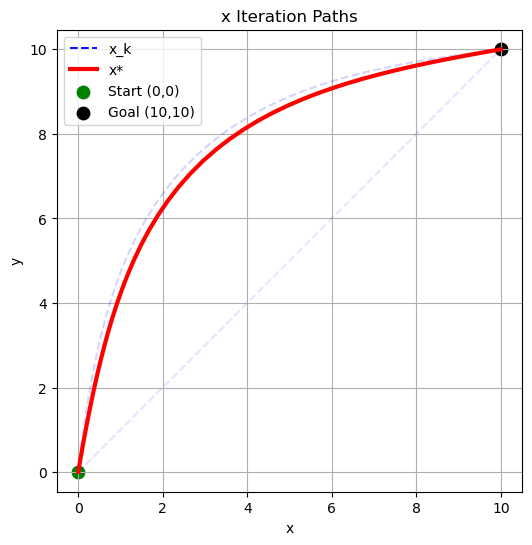

In [115]:
plot_x_paths(log_opt_AD_alm[0], N, len(log_opt_AD_alm[0]))

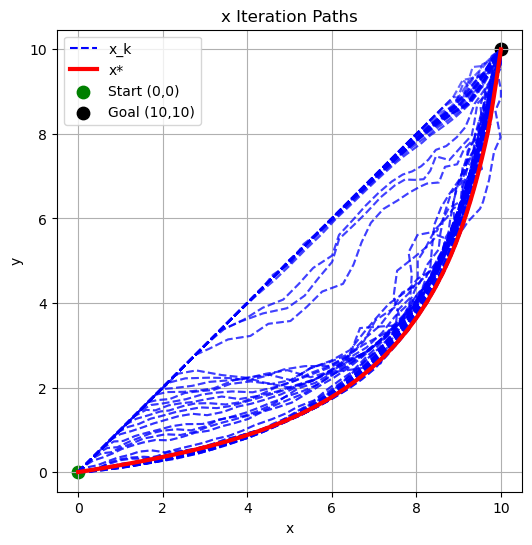

In [148]:
plot_x_paths(x_slsqp, N, len(x_slsqp))

In [152]:
log_f_slsqp[-1]

np.float64(8.097717205241308)

Text(0, 0.5, 'f(xk)')

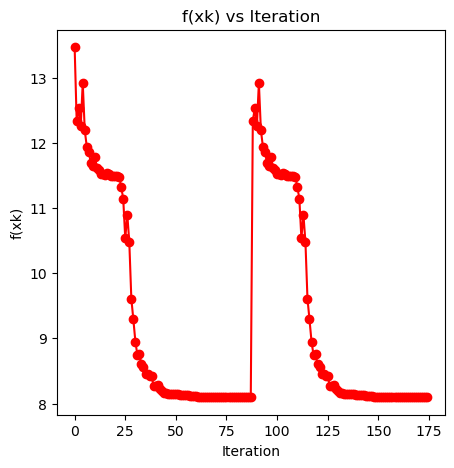

In [150]:
log_f_slsqp = np.array([f(x_k) for x_k in x_slsqp])

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(log_f_slsqp, marker='o', color='red')
axes.set_title('f(xk) vs Iteration')
axes.set_xlabel('Iteration')
axes.set_ylabel('f(xk)')

In [158]:
len(ci)

224

Text(0, 0.5, '|ci(xk)|')

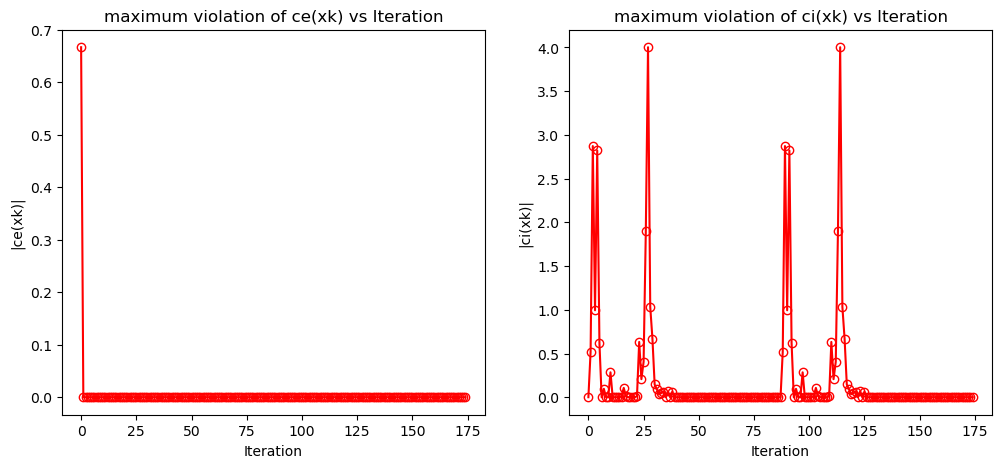

In [166]:
list_max_ce_slsqp = []
list_max_ci_slsqp = []
for x_k in x_slsqp:
    list_max_ce_slsqp.append(max(abs(ce1(x_k)), abs(ce2(x_k)), abs(ce3(x_k)), abs(ce4(x_k)), abs(ce5(x_k)), abs(ce6(x_k))))
    list_max_ci_slsqp.append(max([abs(min(ci_i(x_k), 0)) for ci_i in ci]))

fig, axes = plt.subplots(1, 2, figsize=(6*2, 5))
axes[0].plot(list_max_ce_slsqp, marker='o', color='red', markerfacecolor='none')
axes[0].set_title('maximum violation of ce(xk) vs Iteration')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('|ce(xk)|')

axes[1].plot(list_max_ci_slsqp, marker='o', color='red', markerfacecolor='none')
axes[1].set_title('maximum violation of ci(xk) vs Iteration')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('|ci(xk)|')

In [183]:
print(f'last_ce_slsqp : {list_max_ce_slsqp[-1]}')
print(f'last_ci_slsqp : {list_max_ci_slsqp[-1]}')

last_ce_slsqp : 1.7357682434263162e-32
last_ci_slsqp : 4.699722333394624e-33


#### 내가 짠 SQP 사용 시
---
<등간격으로 dv0 선정 시>  
QP 부문제가 feasible한데도 불구하고 alm4sqp가 QP 부문제의 해를 찾지 못함  
1. ∇L_A이 감소하지 않고 커짐
2. 제약함수(ce_QPk, ci_QPk)의 값이 0을 만족하지 못함
3. 제약함수 값이 어느 정도 작아진 상태에서도 목적함수(Q_QPk) 값이 줄지 않고 계속 늘어남  

결국 alm4sqp가 QP 부문제를 잘 풀지 못한다는 얘기. 왜인지는 모르겠음.  

---

<난수 생성해서 dv0 선정 시>  
너무 신기하게도 잘 풀림(!)  
비록 30분 걸리기는 했지만 어쨌든 해를 찾았음!

In [69]:
N = 45

# 직선 기본 경로
x_base = np.linspace(0, 10, N)
y_base = np.linspace(0, 10, N)

# 난수 perturbation (작은 magnitude)
eps = 2.0   # 난수 perturbation 크기
x = x_base + np.random.uniform(-eps, eps, size=N)
y = y_base + np.random.uniform(-eps, eps, size=N)

# 시작/끝은 다시 고정
x[0], y[0] = 0, 0
x[-1], y[-1] = 10, 10

dv0_sqp = np.concatenate([x, y])

ci = ci_x_larger_0 + ci_x_smaller_10 + ci_y_larger_0 + ci_y_smaller_10 + ci_v_smaller_vmax
ci_torch = ci_x_larger_0_torch + ci_x_smaller_10_torch + ci_y_larger_0_torch + ci_y_smaller_10_torch + ci_v_smaller_vmax_torch
log_opt_AD_sqp = module_opt_AD.sqp(f=f, f_torch=f_torch, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ce_torch=[ce1_torch, ce2_torch, ce3_torch, ce4_torch, ce5_torch, ce6_torch], ci=ci, ci_torch=ci_torch, x0=dv0_sqp, maxiter=40, inner_opt=3, tol=1e-6, tol_inter=1e-3)

max_lm = 11.786892327232122
mu = 11.786892327232122
Dphi1_0 = -211435.392070469
phi1_0 = 26768.780185168573
phi1_k = 315195.50184514
phi1_k = 45883.94056844316
phi1_k = 5129.579071931207

 log - SQP
x01 = [-0.00000031, -1.21182155, 1.73012503, 0.82233011, -0.28448854, 0.80155405, 1.92306451, 1.78659174, 1.93729774, 1.17370549, 1.92107868, 1.70987533, 1.70422209, 2.99155506, 3.18812351, 3.54828976, 2.33802892, 4.21718516, 4.19364324, 5.15653886, 5.43391506, 4.74336819, 4.99870118, 5.37570464, 4.89032737, 6.75239975, 5.72736287, 5.63672196, 5.34734248, 7.29513710, 6.42180184, 7.24308569, 7.04546511, 6.89665638, 7.51351971, 7.34025275, 7.84603725, 7.50027997, 8.23045509, 8.14073575, 8.21649011, 9.13241835, 8.59942572, 9.06701647, 10.00000001, -0.00000008, -0.86383424, -0.37249113, 0.30722601, 1.59627808, 1.82339463, 1.77723961, 1.57084732, 1.79326770, 1.64579059, 1.36198340, 1.35183683, 2.59066553, 3.49242124, 3.21622180, 1.87836666, 1.92636884, 2.35064664, 3.03369832, 3.90142580, 5.08995

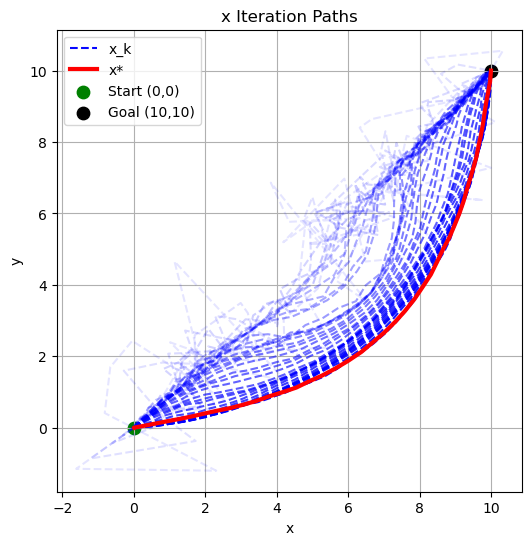

In [184]:
plot_x_paths(log_opt_AD_sqp[0], N, len(log_opt_AD_sqp[0]))

In [155]:
f_sqp[-1]

np.float64(8.098413830635666)

Text(0, 0.5, 'f(xk)')

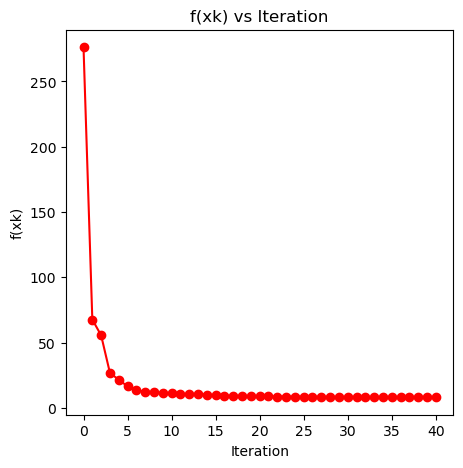

In [154]:
f_sqp = np.array(log_opt_AD_sqp[1])

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(f_sqp, marker='o', color='red')
axes.set_title('f(xk) vs Iteration')
axes.set_xlabel('Iteration')
axes.set_ylabel('f(xk)')

Text(0, 0.5, '|∇L|')

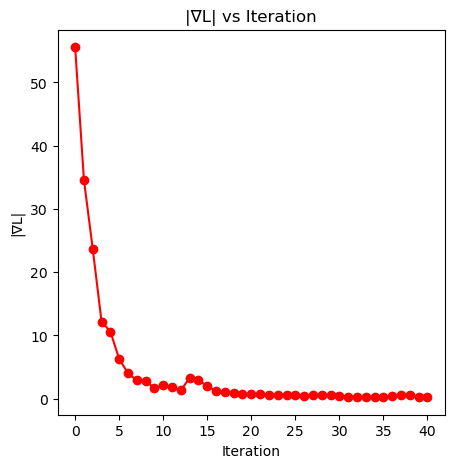

In [89]:
grad_L_sqp = np.array(log_opt_AD_sqp[3])
norm_grad_L_sqp = np.array([np.linalg.norm(grad_L_sqp[i]) for i in range(grad_L_sqp.shape[0])])

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(norm_grad_L_sqp, marker='o', color='red')
axes.set_title('|∇L| vs Iteration')
axes.set_xlabel('Iteration')
axes.set_ylabel('|∇L|')

Text(0, 0.5, '|ci(xk)|')

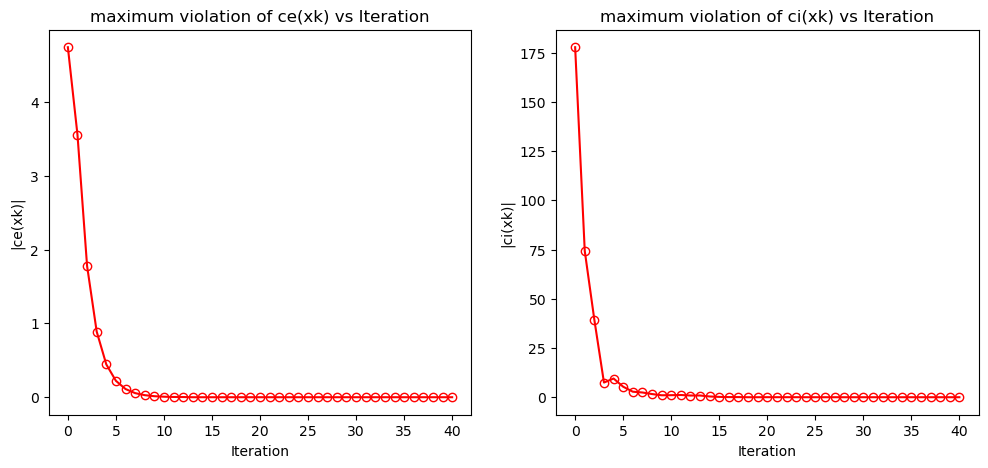

In [179]:
list_max_ce_sqp = [max(np.abs(np.array(ce_k))) for ce_k in log_opt_AD_sqp[4]]
list_max_ci_sqp = np.abs(np.array([np.min(np.minimum(np.array(ci_k), 0)) for ci_k in log_opt_AD_sqp[5]]))

fig, axes = plt.subplots(1, 2, figsize=(6*2, 5))
axes[0].plot(list_max_ce_sqp, marker='o', color='red', markerfacecolor='none')
axes[0].set_title('maximum violation of ce(xk) vs Iteration')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('|ce(xk)|')

axes[1].plot(list_max_ci_sqp, marker='o', color='red', markerfacecolor='none')
axes[1].set_title('maximum violation of ci(xk) vs Iteration')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('|ci(xk)|')

In [180]:
print(f'max_ce_sqp : {list_max_ce_sqp[-1]}')
print(f'max_ci_sqp : {list_max_ci_sqp[-1]}')

max_ce_sqp : 4.506215912545634e-06
max_ci_sqp : 2.354211821555949e-06


In [123]:
x_hist_trust = []
lambda_hist_trust = []
lagr_grad_norm_trust = []

def cb_trust(xk, state):
    # 1) x_k 로그 (xk 가 이미 state.x 복사본이라 이걸 쓰면 됨)
    x_hist_trust.append(xk.copy())

    # 2) 라그랑주 승수 로그
    # state.v 는 보통 [v_eq, v_ineq, v_bounds, ...] 리스트라서 하나로 붙여준다
    v = state.v
    if isinstance(v, (list, tuple)):
        lam_k = np.concatenate([vi.ravel() for vi in v])
    else:
        lam_k = np.ravel(v)
    lambda_hist_trust.append(lam_k)

    # 3) 라그랑지안 gradient norm 로그
    # trust-constr state 객체에 lagrangian_grad 가 있음
    lagr_grad = state.lagrangian_grad
    lagr_grad_norm_trust.append(np.linalg.norm(lagr_grad, ord=2))

    # False/None 리턴하면 계속 진행
    return False

In [126]:
x_slsqp2 = []
x_slsqp2.append(dv0.copy())
res_slsqp = sci_opt.minimize(
    fun=f,
    x0=dv0,
    method='SLSQP',
    constraints=constraints,
    options={'ftol': 1e-8, 'maxiter': 1000, 'disp': True},
    callback=cb
)

print("success:", res_slsqp.success)
print("message:", res_slsqp.message)
print("f_min:", res_slsqp.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.097717205241308
            Iterations: 87
            Function evaluations: 7978
            Gradient evaluations: 87
success: True
message: Optimization terminated successfully
f_min: 8.097717205241308


In [153]:
# 수정된 trust-region 버전:
x_hist_trust.append(dv0_sqp.copy())  # 초기값도 로그에 포함하고 싶으면

res_trust = sci_opt.minimize(
    fun=f,
    x0=dv0,
    method='trust-constr',          # ★ trust-region 기반
    constraints=constraints,
    # jac=grad_f,                   # 목적함수 gradient 있으면 여기에 넣고
    # hess=hess_f,                  # Hessian 있으면 여기에 넣으면 더 좋고
    # callback=cb_trust,              # ★ 위에서 정의한 callback
    options={
        'gtol': 1e-8,               # Lagrangian gradient norm 기준
        'maxiter': 1000,
        'disp': True,
        # 'initial_tr_radius': 1.0, # 필요하면 trust region 초기 반경 세부튜닝
    }
)

print("success:", res_trust.success)
print("message:", res_trust.message)
print("f_min:", res_trust.fun)

# -----------------------------
# 로그를 numpy array로 정리
# -----------------------------
x_hist = np.asarray(x_hist_trust)                      # shape: (nit+1, n_var)
lambda_hist = np.asarray(lambda_hist_trust)           # shape: (nit, n_constr_total)
lagr_grad_norm_hist = np.asarray(lagr_grad_norm_hist)  # shape: (nit,)

/home/cykwonlab/miniconda3/envs/general_purpose/lib/python3.13/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 90909, CG iterations: 3464, optimality: 3.47e-02, constraint violation: 1.25e-06, execution time: 1.7e+02 s.
success: False
message: The maximum number of function evaluations is exceeded.
f_min: 12.232486122737754
